In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle

In [7]:
DATA_DIR = "data/oasis_longitudinal.csv"
df = pd.read_csv(DATA_DIR)

Link to Dataset: https://www.kaggle.com/hyunseokc/detecting-early-alzheimer-s

`EDUC`: Years of Education \
`SES` : Socioeconomic status \
`MMSE` : Mini Mental State Examination \
`CDR` : Climincal Dementia Rating \
`eTIV` : Estimated Total Intracranial Volume \
`nWBV` : Normalized Whole Brain Volume \
`ASF` : Atlas Scaling Factor

In [3]:
df = df.dropna(axis=0)
df.shape

(354, 15)

## Defining the dataset

In [8]:
# Dataset Definition
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
class AlzheimersDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.df = pd.read_csv(root_dir)
        cols_to_drop = ['Visit', 'Subject ID', 'MRI ID', 'Hand', 'M/F']
        self.df = self.df.dropna(axis=0)
        self.df = self.df.drop(cols_to_drop, axis=1)
        labels = [1 if group == 'Demented' else 0 for group in self.df.Group]
        self.df.Group = labels
        self.data = self.df.to_numpy()
    def __getitem__(self, i):
        return self.data[i]
    def __len__(self):
        return self.data.shape[0]

In [9]:
def generate_batch(batch):
    label = [entry[0] for entry in batch]
    inputs = [entry[1:] for entry in batch]
    return inputs, label

In [23]:
alzh_data = AlzheimersDataset(DATA_DIR)
train_len = int(len(alzh_data) * 0.9) # 10% Split
train_dataset, test_dataset = random_split(alzh_data, \
                                           [train_len, \
                                            len(alzh_data) - train_len
                                           ])

print("train_dataset length: {0} | test_dataset length: {1}".format(len(train_dataset), \
                                                                 len(test_dataset)))

<class 'torch.utils.data.dataset.Subset'>
train_dataset length: 318 | test_dataset length: 36


## Data Visualization

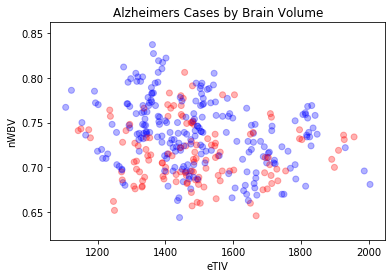

In [47]:
c_list = []
for label in alzh_data.df.Group:
    if label == 1:
        c_list.append('r')
    else:
        c_list.append('b')

def scatter(df, title, x, y, c):
    fig, ax = plt.subplots()
    ax.scatter(df[x], df[y], c=c, alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    plt.show()
# plt.scatter(alzh_data.df.eTIV, alzh_data.df.nWBV, \
#            c = c_list)
# plt.title('Alzheimers Cases by Brain Volume')

scatter(alzh_data.df, \
        "Alzheimers Cases by Brain Volume", \
        "eTIV", "nWBV", c_list)

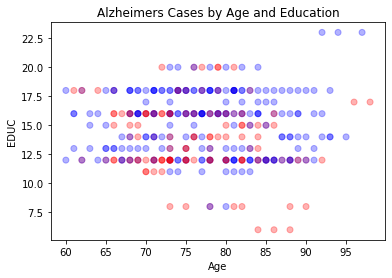

In [48]:
scatter(alzh_data.df, \
        "Alzheimers Cases by Age and Education", \
        'Age', 'EDUC', c_list)

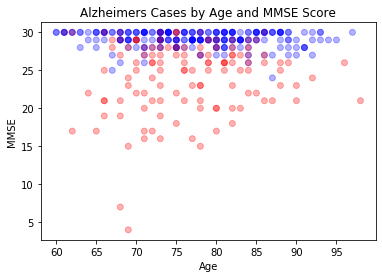

In [49]:
scatter(alzh_data.df, \
       "Alzheimers Cases by Age and MMSE Score", \
       "Age", "MMSE", c_list)

## Training SVM

In [14]:
# SVM
from sklearn.svm import SVC
def train_SVM(x, y, params):
    clf = SVC(**params)
    clf.fit(x, y)
    return clf

In [20]:
def save_sklearn_model(clf, filename):
    if '.sav' in filename:
        path = "models/"+filename
        pickle.dump(clf, open(path, 'wb'))
    else:
        print("Incorrect file extension")

In [16]:
svm_params = {
    'C': 1,
    'kernel': 'poly',
    'gamma': 'auto',
    'degree': 2
}
train_x, train_y = generate_batch(train_dataset)
test_x, test_y = generate_batch(test_dataset)

In [17]:
clf = train_SVM(train_x, train_y, svm_params)

In [87]:
from sklearn.metrics import confusion_matrix
def report(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
#     print(cm)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    
    tpr = tp / (tp+fn)
    tnr = tn / (tn+fp)
    
    precision = tp / (tp+fp)
    fpr = 1 - tnr
    fnr = 1 - tpr
    
    scores = [precision, tpr, tnr, fpr, fnr]
    cols = ['precision', 'tpr', 'tnr', 'fpr', 'fnr']
    for i, col in enumerate(cols):
        print('{}: {:.4}'.format(col, scores[i]))
    
    return scores, cols

y_pred = clf.predict(train_x)
scores, cols = report(y_pred, train_y)
print("train_score: {:.4}%, test_score: {:.4}%".format(clf.score(train_x, train_y)*100, \
                                                clf.score(test_x, test_y)*100))

precision: 0.9352
tpr: 0.9266
tnr: 0.9665
fpr: 0.03349
fnr: 0.07339
train_score: 95.28%, test_score: 91.67%


In [22]:
save_sklearn_model(clf, 'alzheimers_svm.sav') # Saves the SVM model

### Testing the SVM

#### Prediction using Linear SVM

accuracy: 91.7%


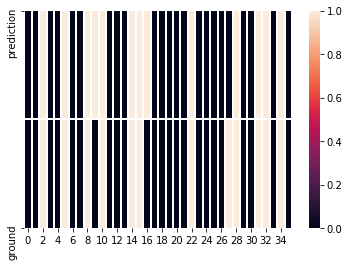

precision: 0.8462
tpr: 0.9167
tnr: 0.9167
fpr: 0.08333
fnr: 0.08333


In [88]:
import seaborn as sns
from sklearn.metrics import accuracy_score
model_path = 'models/alzheimers_svm.sav'
model = pickle.load(open(model_path, 'rb'))

def make_predictions(testset, model):
    predictions = []
    ground = []
    for row in testset:
        x = row[1:]
        predictions.append(int(model.predict([x])))
        ground.append(row[0])
    return (predictions, ground)

def show_predictions(results):
    hm_data = np.reshape(np.array(results), (2, -1))
    ax = sns.heatmap(hm_data, linewidth=1, yticklabels=['prediction', 'ground'])
    accuracy = accuracy_score(results[1], results[0])
    print('accuracy: {:.3}%'.format(accuracy*100))
    plt.show()

predictions_test, ground_test = make_predictions(test_dataset, model)
show_predictions(make_predictions(test_dataset, model))
scores, cols = report(*make_predictions(test_dataset, model))

## Training a Linear NN

In [12]:
# Models
# - SVM
# - Linear NN
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlzheimersNN(nn.Module):
    
    def __init__(self, input_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embed_dim)
        self.linear = nn.Linear(embed_dim, 2)
        self.sigmoid = nn.Sigmoid()
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
    
    def forward(self, inp):
        embeds = self.embedding(inp)
        out = self.linear(embeds)
#         out = self.sigmoid(out)
        return out

In [13]:
def generate_batch_tensor(batch):
    label = torch.tensor([entry[0] for entry in batch])
    inputs = torch.tensor([entry[1:] for entry in batch]).long()
    return inputs, label

In [14]:
def train_func(sub_train_):
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True, \
                      collate_fn=generate_batch_tensor)
    for i, (inputs, label) in enumerate(data):
        optimizer.zero_grad()
        inputs, label = inputs.to(device), label.to(device)
        
        output = model(inputs)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == label).sum().item()
    
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

In [69]:
import time
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# BATCH_SIZE = 4
# EMBED_DIM = 16
# N_EPOCHS = 5

# train_losses = []
# valid_losses = []

# model = AlzheimersNN(10, EMBED_DIM).to(device)
# criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

# train_len = int(len(train_dataset) * 0.95)
# sub_train_, sub_valid = \
#     random_split(train_dataset, [train_len, len(train_dataset) - train_len])
# print("Training on {}".format(device))

# for epoch in range(N_EPOCHS):

#     start_time = time.time()
#     train_loss, train_acc = train_func(sub_train_)
#     valid_loss, valid_acc = test(sub_valid)
#     train_losses.append(train_loss)
#     val_losses.append(valid_loss)
#     secs = int(time.time() - start_time)
#     mins = secs / 60
#     secs = secs % 60

#     print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
#     print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
#     print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

# torch.save(model, "saved_models/linear_nn.pth")